In [1]:
import nengo
import nengo_spa as spa
import numpy as np

In [7]:
from matplotlib import pyplot as plt

In [2]:
words = [ 'CAT', 'BLUE', 'RED']
colors = ['RED', 'BLUE']
fingers = ['INDEX', 'MIDDLE']

D = 16
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(words))
vocab.populate('COLOR; WORD')
vocab.populate(';'.join(fingers))

stimuli = []
for i in range(10):
    w = np.random.choice(words)
    c = np.random.choice(colors)
    stimuli.append((w,c))

In [3]:
model = spa.Network()
with model:
   
    t_stim = 0.5
    t_isi = 0.5
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    pre_stim_c = spa.Transcode(color_func, output_vocab=vocab)    
    stim_c = spa.State(vocab)    
   
    attention = spa.State(vocab, neurons_per_dimension=10)
    spa.sym.WORD * 0.45 + spa.sym.COLOR * 0.55 >> attention
   
    wm = spa.State(vocab)
   
    nengo.Connection(pre_stim_c.output, stim_c.input, synapse=0.3)
   
    (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~attention*2 >> wm
   
    finger = spa.State(vocab)
   
    with spa.ActionSelection():
        spa.ifmax( spa.dot(wm, spa.sym.BLUE),
            spa.sym.INDEX >> finger)
        spa.ifmax(spa.dot(wm, spa.sym.RED),
            spa.sym.MIDDLE >> finger)
        spa.ifmax(0.5,
            spa.semantic_pointer.Zero(D) >> finger)

In [4]:
with model:
    p_input_word = nengo.Probe(stim_w.output)
    p_input_color = nengo.Probe(pre_stim_c.output)
    p_wm = nengo.Probe(wm.output)
    p_finger = nengo.Probe(finger.output)

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(5)

Build finished in 0:00:04.                                                      
Simulation finished in 0:00:33.                                                 


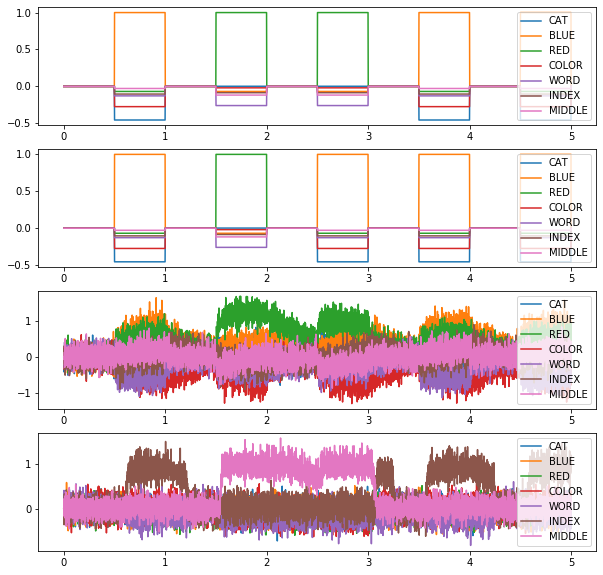

In [8]:
figuge, axs = plt.subplots(ncols=1, nrows=4, figsize=(10, 10))

axs[0].plot(sim.trange(), spa.similarity(sim.data[p_input_word], vocab))
axs[0].legend(vocab.keys(), loc='right')

axs[1].plot(sim.trange(), spa.similarity(sim.data[p_input_color], vocab))
axs[1].legend(vocab.keys(), loc='right')

axs[2].plot(sim.trange(), spa.similarity(sim.data[p_wm], vocab))
axs[2].legend(vocab.keys(), loc='right')

axs[3].plot(sim.trange(), spa.similarity(sim.data[p_finger], vocab))
axs[3].legend(vocab.keys(), loc='right')
